In [1]:
from main import *
from visualization import *
from stats import *

from scipy.stats import pearsonr, spearmanr, zscore

%matplotlib inline
plt.rcParams['font.size'] = 18

# Loading data

In [2]:
top_directory = '/media/anleg84/KINGSTON/Datasets/Networks2024/'
datasets = get_datasets(top_directory, keywords=['920nm'], exclude=[])

atlas_path = '/home/anleg84/Documents/Atlas/MapzebrainOld/'
atlas = MapzebrainAtlas(atlas_path)

In [3]:
excluded = np.load('Results/excluded_regions.npy')

n_neurons_per_region = np.load('Results/N_neurons_per_region.npy')

# Supplementary: Investigating functional diversity in each brain region

## Computing the regional average correlation with mean signal

For each brain region, computes the average activity trace. Then, correlates this average trace with all individual neuronal time series from the region, and finally averages these correlations. This yields a single score per brain region that describes the internal coherence of activity patterns. The larger the brain region, the less representative the average trace tends to be, unless the region has very high internal coherence. As a null model of this measure, internal correlations with the mean are compared with similar measures compiled on temporally permuted time series.

In [5]:
def compute_avg_correlation_with_mean(timeseries, region_labels):
    avg_with_mean = []
    for i in range(region_labels.shape[1]):
        timeseries_ = timeseries[region_labels[:, i] != 0]
        if np.any(timeseries_):
            if timeseries_.shape[0] > 1:
                mean_signal = np.mean(timeseries_, axis=0)
                ts_cat = np.concatenate([mean_signal[None, :], timeseries_], axis=0)
                corrs = np.corrcoef(ts_cat)
                avg_with_mean.append(np.mean(corrs[0][1:]))
            else:
                avg_with_mean.append(np.nan)
        else:
            avg_with_mean.append(np.nan)
    return avg_with_mean

def randomize_timeseries(timeseries):
    "For each time series, preserves numerical values but randomly reorders them, breaking all temporal structure."
    randomized = np.copy(timeseries)
    random_ids = np.arange(timeseries.shape[1])
    for i in range(randomized.shape[0]):
        np.random.shuffle(random_ids)
        randomized[i] = timeseries[i][random_ids]
    return randomized

In [6]:
avg_with_mean = []

for folder in tqdm(datasets):
    
    data = load_data(folder)
    dff = filter_timeseries(np.load(folder + 'dff.npy')[:, 60:630], 1)
    avg_with_mean.append(compute_avg_correlation_with_mean(dff, data['region_labels']))

100%|███████████████████████████████████████████| 22/22 [01:43<00:00,  4.72s/it]


In [7]:
avg_with_mean_permuted = []
#avg_with_mean_randomized = []

for folder in tqdm(datasets):
    
    data = load_data(folder)
    dff = filter_timeseries(np.load(folder + 'dff.npy')[:, 60:630], 1)
    for _ in range(10):
        dff_permuted = permute_timeseries(dff)
        avg_with_mean_permuted.append(compute_avg_correlation_with_mean(dff_permuted, data['region_labels']))
        #dff_randomized = randomize_timeseries(dff)
        #avg_with_mean_randomized.append(compute_avg_correlation_with_mean(dff_randomized, data['region_labels']))

100%|███████████████████████████████████████████| 22/22 [08:52<00:00, 24.21s/it]


#### Plotting all points

In [8]:
x1 = np.delete(n_neurons_per_region, excluded, axis=1).flatten()
y1 = np.delete(np.array(avg_with_mean), excluded, axis=1).flatten()

excluded_ids = np.where((x1 == 0) | (np.isnan(y1)))[0]
x1 = np.delete(x1, excluded_ids)
y1 = np.delete(y1, excluded_ids)

x2 = []
for i in range(len(datasets)):
    for _ in range(10):
        x2.append(np.delete(n_neurons_per_region[i], excluded))
x2 = np.concatenate(x2)
y2 = np.delete(np.array(avg_with_mean_permuted), excluded, axis=1).flatten()
excluded_ids = np.where((x2 == 0) | (np.isnan(y2)))[0]
x2 = np.delete(x2, excluded_ids)
y2 = np.delete(y2, excluded_ids)

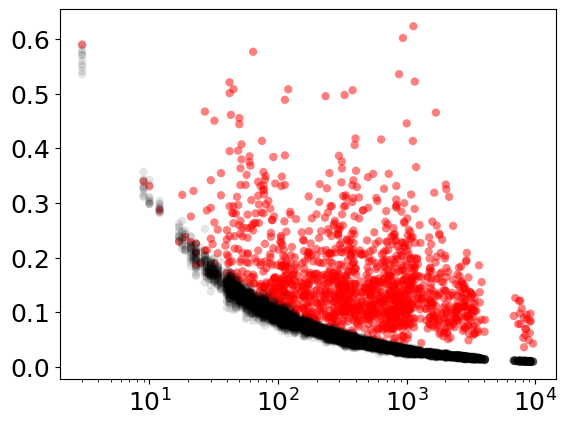

In [9]:
plt.scatter(x1, y1, color='red', edgecolor='None', alpha=0.5)
plt.scatter(x2, y2, color='black', edgecolor='None', alpha=0.1)

plt.xscale('log')

In [10]:
np.save('Results/supp_averaging_x1.npy', x1)
np.save('Results/supp_averaging_y1.npy', y1)
np.save('Results/supp_averaging_x2.npy', x2)
np.save('Results/supp_averaging_y2.npy', y2)

As we can see above, empirical correlations with the mean (in red) greatly exceed correlations from permuted timeseries (in black) for varying brain region sizes. This means that individual time series are in general significantly correlated with the mean trace from the brain region, except a few rare cases (some red points that overlap with the black cloud, corresponding to invidividual regional measurements in some larvae).

## Plotting example neurons in Pallium

In [13]:
from rastermap import Rastermap

def compute_rastermap(timeseries, locality=0.5, time_lag_window=5, return_embedding=False):
    model = Rastermap(locality=locality, time_lag_window=time_lag_window).fit(timeseries)
    if return_embedding:
        return model.embedding
    else:
        return model.isort

/home/anleg84/anaconda3/envs/calimba/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [12]:
folder = datasets[8]
    
data = load_data(folder)
dff = filter_timeseries(np.load(folder + 'dff.npy')[:, 60:630], 1)
in_pallium = data['region_labels'][:, 3] != 0
dff_pallium = dff[in_pallium]

In [20]:
with temp_random_state(420):
    order = compute_rastermap(dff_pallium)

2025-03-20 19:16:23,499 [INFO] normalizing data across axis=1
2025-03-20 19:16:23,511 [INFO] projecting out mean along axis=0
2025-03-20 19:16:23,523 [INFO] data normalized, 0.02sec
2025-03-20 19:16:23,524 [INFO] sorting activity: 3128 valid samples by 570 timepoints
2025-03-20 19:16:24,560 [INFO] n_PCs = 200 computed, 1.06sec
2025-03-20 19:16:24,946 [INFO] 100 clusters computed, time 1.45sec
2025-03-20 19:16:35,147 [INFO] clusters sorted, time 11.65sec
2025-03-20 19:16:35,481 [INFO] clusters upsampled, time 11.98sec
2025-03-20 19:16:35,492 [INFO] rastermap complete, time 11.99sec


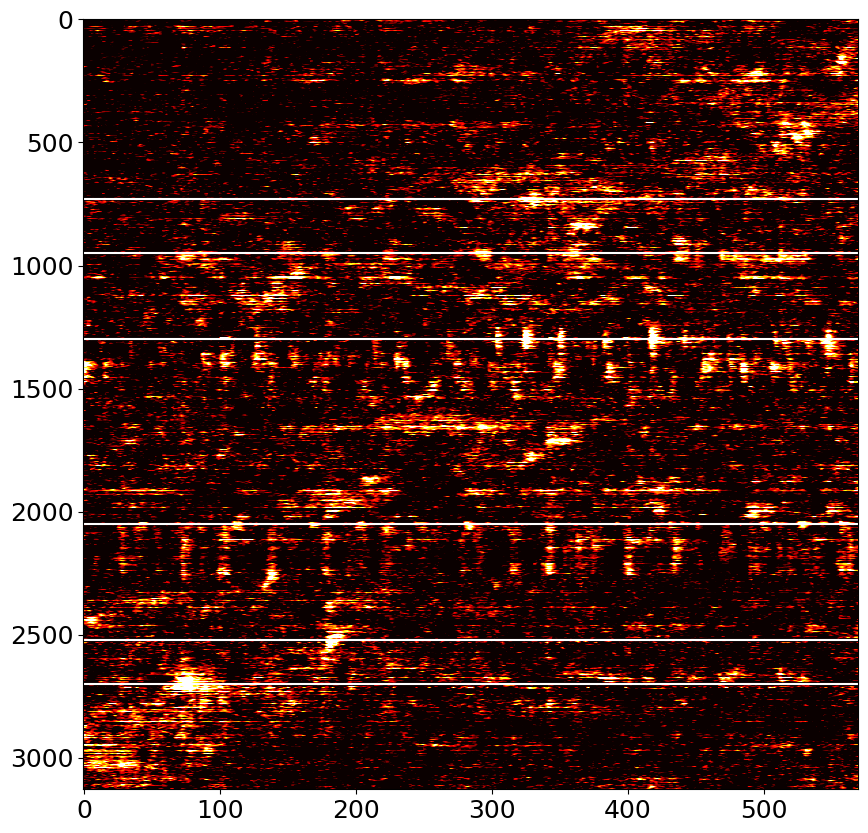

In [27]:
plt.figure(figsize=(10, 10))
plt.imshow(dff_pallium[order], cmap='hot', aspect='auto', vmin=0.75, vmax=2)
plt.axhline(730, color='white')
plt.axhline(950, color='white')
plt.axhline(1300, color='white')
plt.axhline(2050, color='white')
plt.axhline(2520, color='white')
plt.axhline(2700, color='white')

In [35]:
np.save('Results/supp_averaging_sorting_pallium.npy', order)

In [36]:
window = 25

signals = []
indices = [730, 950, 1300, 2050, 2520, 2700]
for i in indices:
    signals.append(dff_pallium[order][i-window:i+window])

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

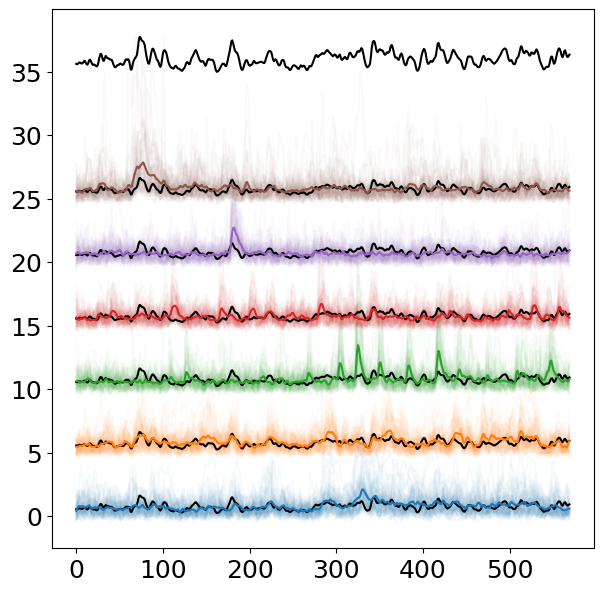

In [37]:
plt.figure(figsize=(7, 7))
avg_signal = np.mean(dff_pallium, axis=0)
avg_signal -= np.mean(avg_signal)
for i in range(len(signals)):
    offset = i * 5
    for s in signals[i]:
        plt.plot(s + offset, color=colors[i], alpha=0.03)
    plt.plot(avg_signal * 5 + offset + 0.75, color='black')
    plt.plot(np.mean(signals[i], axis=0) + offset, color=colors[i])
    
plt.plot(avg_signal * 10 + ((i+1) * 6), color='black')

# Rendering figure

In [113]:
%matplotlib inline

In [150]:
folder = datasets[8]
    
data = load_data(folder)
dff = filter_timeseries(np.load(folder + 'dff.npy')[:, 60:630], 1)
data['region_labels'][:, 10] = 0
in_pallium = data['region_labels'][:, 3] != 0
dff_pallium = dff[in_pallium]
in_brain = np.sum(data['region_labels'], axis=1) > 0
in_brain[in_pallium] = False

x1 = np.load('Results/supp_averaging_x1.npy')
y1 = np.load('Results/supp_averaging_y1.npy')
x2 = np.load('Results/supp_averaging_x2.npy')
y2 = np.load('Results/supp_averaging_y2.npy')

order = np.load('Results/supp_averaging_sorting_pallium.npy')

window = 25
signals = []
indices = [730, 950, 1300, 2050, 2520, 2700]
for i in indices:
    signals.append(dff_pallium[order][i-window:i+window])

In [152]:
den = 300
colors = [[1, 0, 0],
         [178/den, 161/den, 255/den],
         [44/den, 166/den, 255/den],
         [47/den, 216/den, 180/den],
         [255/den, 183/den, 0/den],
         'brown']

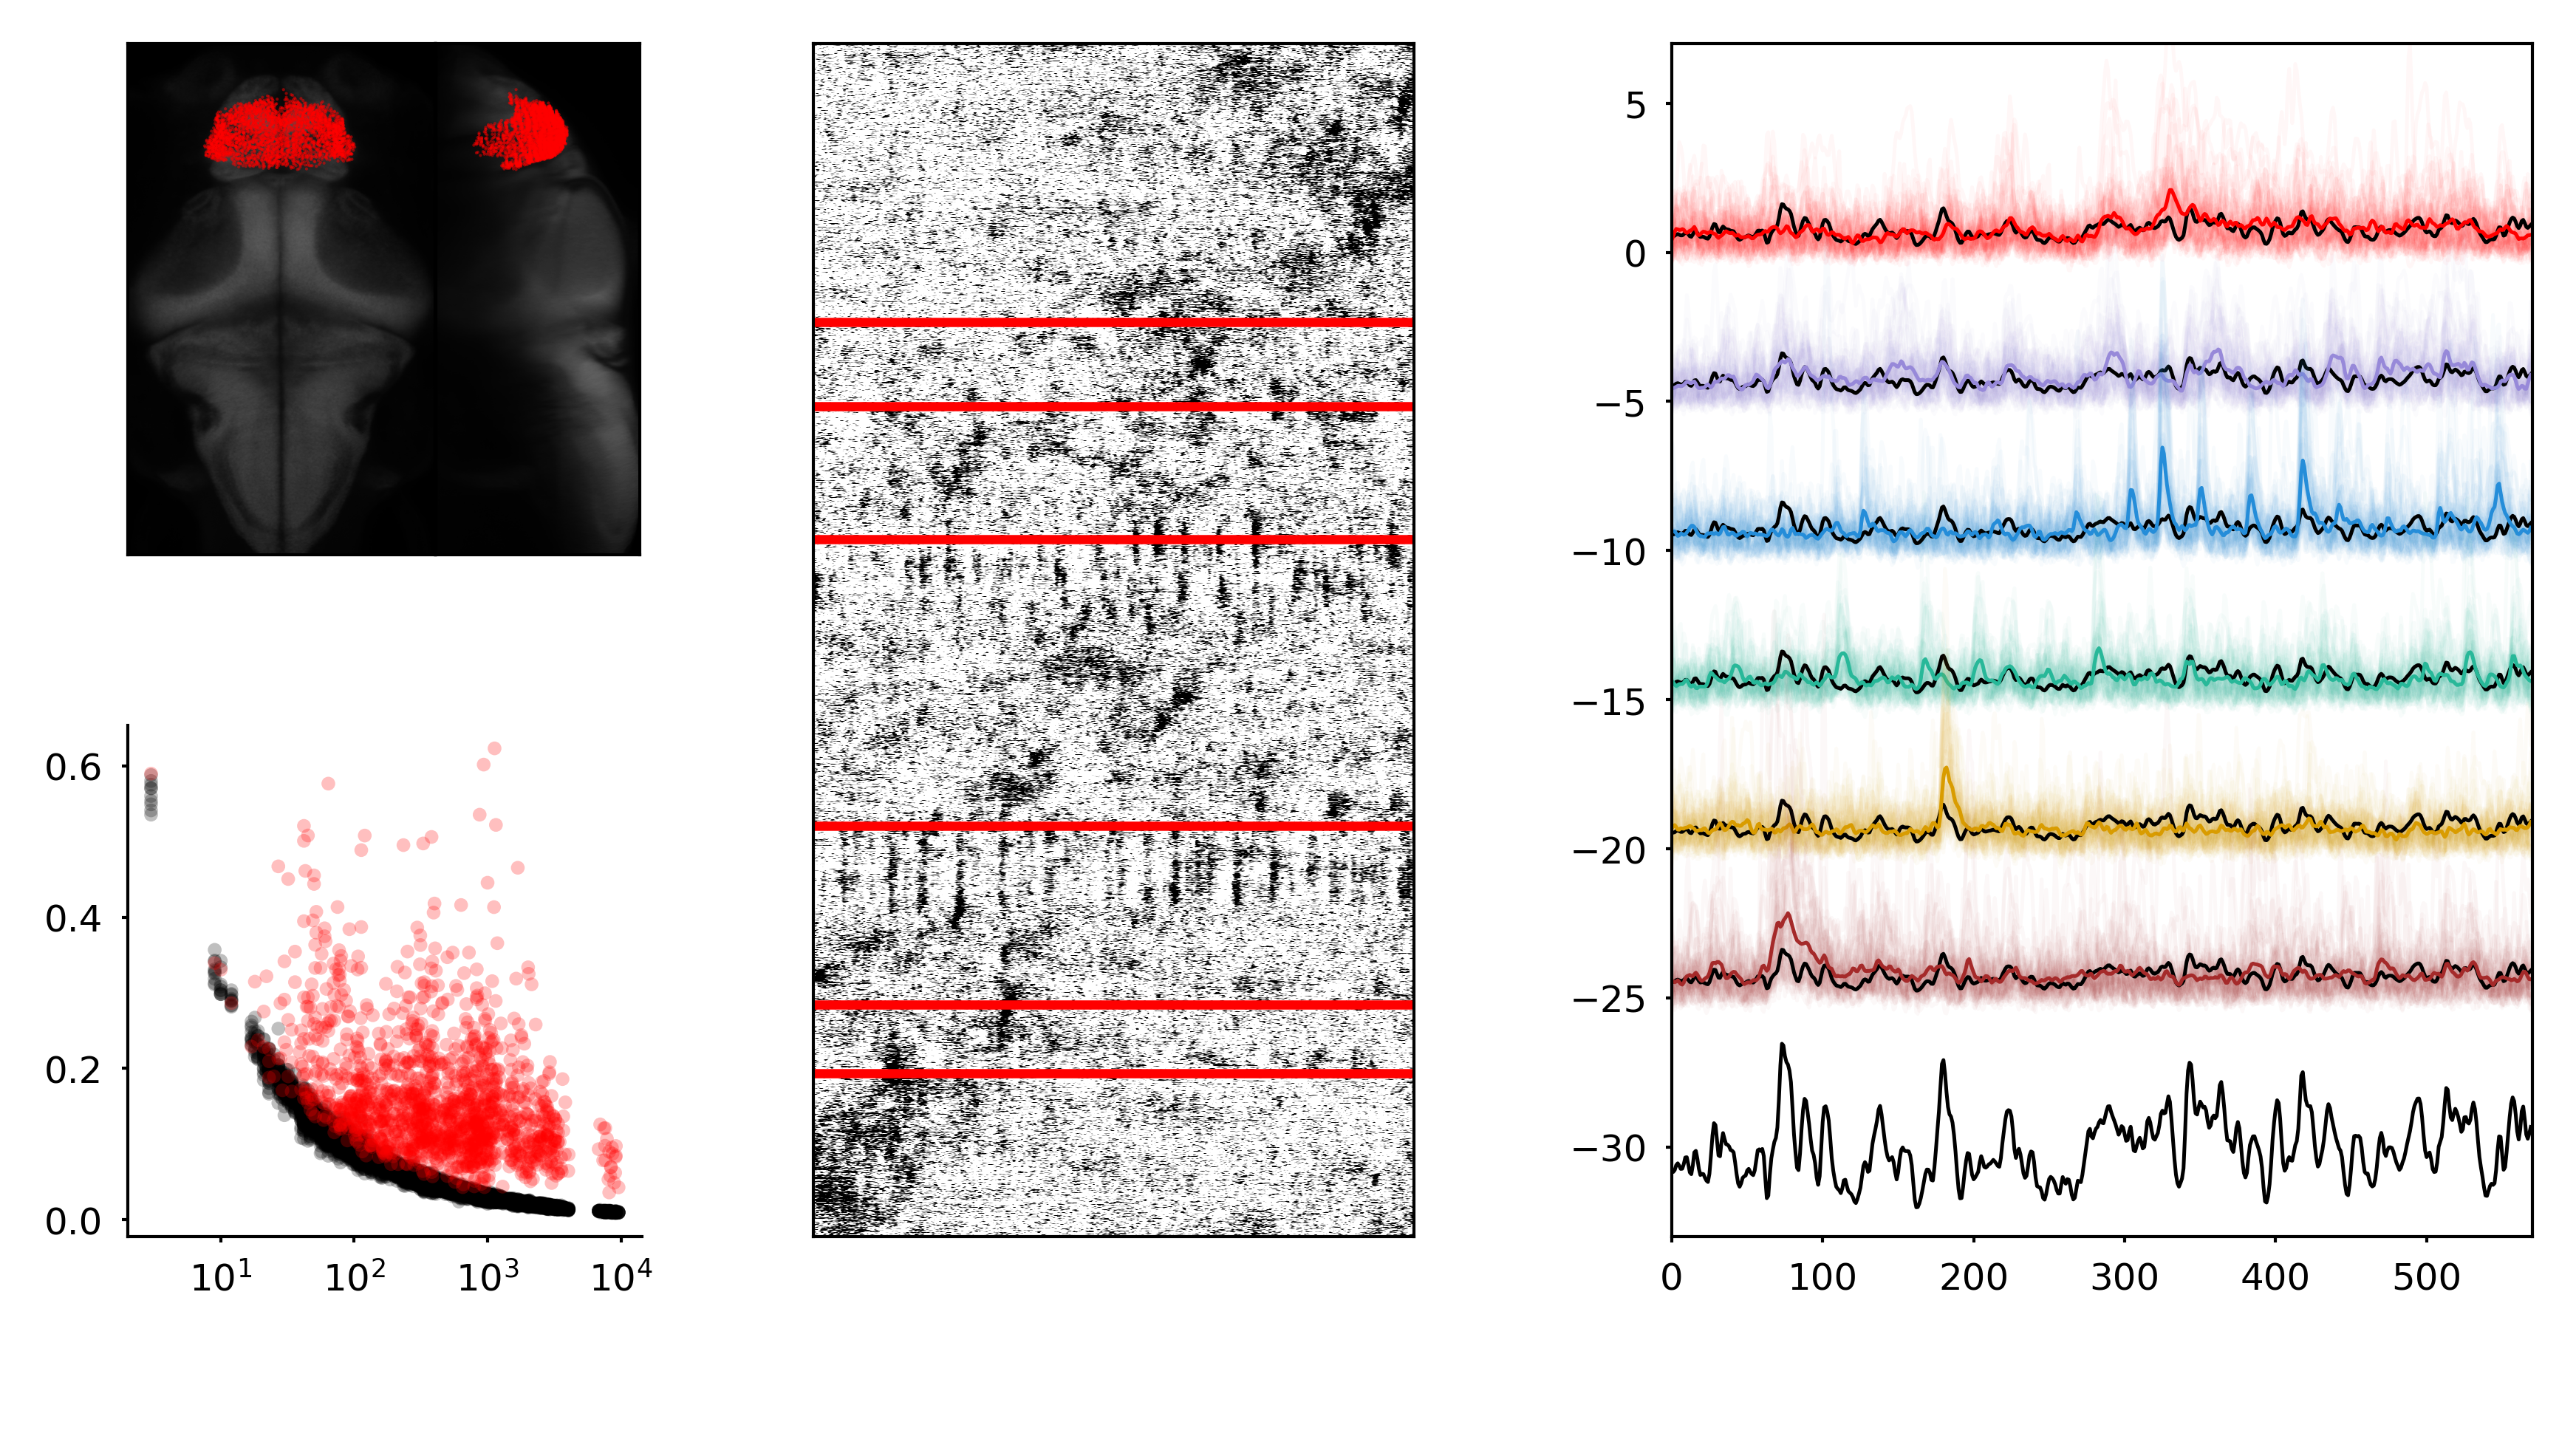

In [173]:
fig = PaperFigure(figsize=(7, 4), dpi=600)

fig.set_tick_length(1)
fig.set_font_size(6)
fig.add_background()

# Adding panels -------------------------------

w = 1.5
pad = (5 - 4 * w) / 3
fig.add_axes('top', (0, 0), 0.6 * w, w)
fig.add_axes('side', (0.6 * w, 0), 0.4 * w, w)
fig.add_axes('raster', (2, 0), 1.75, 2 * w + 0.5)
fig.add_axes('timeseries', (4.5, 0), 5, 2 * w + 0.5)
fig.add_axes('scatter', (0, w + 0.5), w, w)

fig.set_line_thickness(0.5)

# Content -------------------------------------

centroids = data['centroids_atlas']
ax = fig.axes['top']
ax.imshow(atlas.XYprojection, cmap='gray', aspect='auto', vmax=250)
#ax.scatter(centroids[in_brain, 0], centroids[in_brain, 1], color='white', edgecolor='None', s=1, alpha=0.05)
ax.scatter(centroids[in_pallium, 0], centroids[in_pallium, 1], color=colors[0], edgecolor='None', s=0.25, alpha=0.5, rasterized=True)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([65, 505])
ax.set_ylim([850, 50])

ax = fig.axes['side']
ax.imshow(np.rot90(atlas.XZprojection, k=-1), cmap='gray', aspect='auto', vmax=250)
#ax.scatter(359 - centroids[in_brain, 2], centroids[in_brain, 1], color='white', edgecolor='None', s=1, alpha=0.05)
ax.scatter(359 - centroids[in_pallium, 2], centroids[in_pallium, 1], color=colors[0], edgecolor='None', s=0.25, alpha=0.5, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([50, 359])
ax.set_ylim([850, 50])

ax = fig.axes['raster']
ax.imshow(zscore(dff_pallium[order], axis=1), cmap='binary', aspect='auto', vmin=0, vmax=1)
ax.axhline(730, color='red')
ax.axhline(950, color='red')
ax.axhline(1300, color='red')
ax.axhline(2050, color='red')
ax.axhline(2520, color='red')
ax.axhline(2700, color='red')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['timeseries']
lw = 0.6
avg_signal = np.mean(dff_pallium, axis=0)
avg_signal -= np.mean(avg_signal)
for i in range(len(signals)):
    offset = -(i * 5)
    for s in signals[i]:
        ax.plot(s + offset, color=colors[i], alpha=0.03, linewidth=lw)
    ax.plot(avg_signal * 5 + offset + 0.75, color='black', linewidth=lw)
    ax.plot(np.mean(signals[i], axis=0) + offset, color=colors[i], linewidth=lw)
offset = -(i * 6)
ax.plot(avg_signal * 20 + offset, color='black', linewidth=lw)
ax.set_xlim([0, len(avg_signal)])
ax.set_ylim([-33, 7])
#ax.axis('off')

ax = fig.axes['scatter']
ax.scatter(x2, y2, color='black', edgecolor='None', s=5, alpha=0.25, rasterized=True)
ax.scatter(x1, y1, color=colors[0], edgecolor='None', s=5, alpha=0.25, rasterized=True)
ax.set_xscale('log')
ax.spines[['top', 'right']].set_visible(False)
ax.set_xticks([10, 10**2, 10**3, 10**4])

# Displaying ----------------------------------

fig.save('/home/anleg84/Documents/Figures/PaperNetworks2024/supp_averaging_incomplete.svg')

fig.show()

#### Manually indicated values (added in Inkscape)

In [180]:
pearsonr(np.log(x1), y1)

(-0.38431480144236857, 4.6758130705631733e-51)

In [162]:
dff_pallium.shape

(3128, 570)

In [ ]:
139.793

In [164]:
630 - 60

570

In [169]:
(60/ (570 * 0.986)) * 139.793

14.923988470161204

In [174]:
5 / 20

0.25

In [175]:
24.302 * 0.8

19.4416

In [176]:
(50 / 3128) * 194.289

3.1056425831202046